Epoch 0, Training Loss: 0.3173154890537262, Testing Loss: 0.31086909770965576
Epoch 100, Training Loss: 0.15656742453575134, Testing Loss: 0.17100243270397186
Epoch 200, Training Loss: 0.1367349624633789, Testing Loss: 0.15337423980236053
Epoch 300, Training Loss: 0.12587983906269073, Testing Loss: 0.14229340851306915
Epoch 400, Training Loss: 0.1175653263926506, Testing Loss: 0.13286375999450684


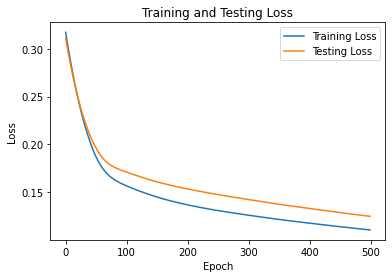

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()

        # Number of hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # RNN Layer
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Initialize input-to-hidden weight to the identity matrix
        for l in range(layer_dim):
            weight_ih_name = f"weight_ih_l{l}"
            weight_ih = getattr(self.rnn, weight_ih_name)
            weight_ih.data.copy_(torch.eye(hidden_dim))
            weight_ih.requires_grad = False

        # Initialize hidden-to-output weights as the identity matrix in the Readout layer
        self.fc.weight.data.copy_(torch.eye(output_dim, hidden_dim))
        self.fc.weight.requires_grad = False

    # Forward pass
    def forward(self, x, k=1):
        # Initial hidden state
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        outputs = []
        for _ in range(k):
            # One step of the RNN
            out, h0 = self.rnn(x, h0)

            # Process the RNN output through the FC layer
            out = self.fc(out[:, -1, :])

            # Append the output
            outputs.append(out)

            # Use the current output as the next input (Reshape it properly)
            x = out.unsqueeze(1)

        # Stack outputs to have them in [batch, k, output_dim] shape
        return torch.stack(outputs, dim=1)

# Parameters
input_dim = 10    # Dimension of the input
hidden_dim = 10   # Dimension of the hidden state
output_dim = 10   # Dimension of the output
layer_dim = 1     # Number of hidden layers
k = 3             # Number of steps to predict ahead
batch_size = 64   # Batch size

# Simulate data
x_data = torch.rand((batch_size, k + 1, input_dim))

# Training Data: input sequence
x_train = x_data[:, :-k, :]

# Training Data: target sequence (next k steps)
y_train = x_data[:, -k:, :]

x_test = torch.rand((batch_size, k + 1, input_dim))
y_test = x_test[:, -k:, :]

# Model
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 500
training_losses = []  # Store the training losses here
testing_losses = []   # Store the testing losses here

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train, k)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    # Evaluate the model on the testing data
    model.eval()
    with torch.no_grad():
        outputs_test = model(x_test[:, :-k, :], k)
        loss_test = criterion(outputs_test, y_test)
        testing_losses.append(loss_test.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Training Loss: {loss.item()}, Testing Loss: {loss_test.item()}')

import matplotlib.pyplot as plt
# Plotting the training and testing loss
plt.plot(training_losses, label='Training Loss')
plt.plot(testing_losses, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [2]:
import curbd

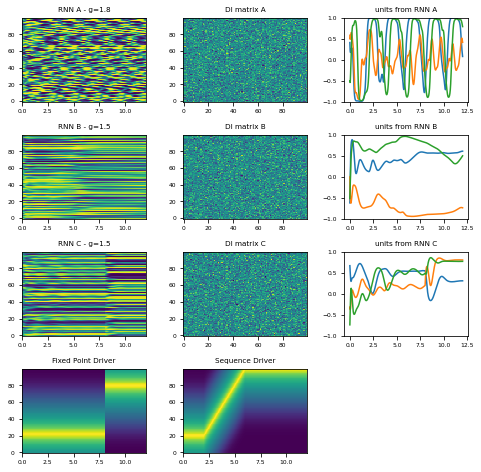

In [3]:
sim = curbd.threeRegionSim(number_units=100)

activity = np.concatenate((sim['Ra'], sim['Rb'], sim['Rc']), 0)

In [4]:
print(activity.shape)

(300, 1201)


(300, 1201)
Epoch 0, Training Loss: 8.453917589708144, Testing Loss: 1.783016233543516
Epoch 10, Training Loss: 0.2501944372052903, Testing Loss: 0.24294189912555805
Epoch 20, Training Loss: 0.21001997220484955, Testing Loss: 0.20846638320432062
Epoch 30, Training Loss: 0.20067443209902328, Testing Loss: 0.20016797489518057
Epoch 40, Training Loss: 0.19668146741286893, Testing Loss: 0.1963805311410559
Epoch 50, Training Loss: 0.19393093788423058, Testing Loss: 0.19368752677269632
Epoch 60, Training Loss: 0.19156566047722207, Testing Loss: 0.19133874339719925
Epoch 70, Training Loss: 0.18936910619857955, Testing Loss: 0.18912819166729256
Epoch 80, Training Loss: 0.1869188379873792, Testing Loss: 0.18663888501326045
Epoch 90, Training Loss: 0.18457128716855045, Testing Loss: 0.18436973486586125


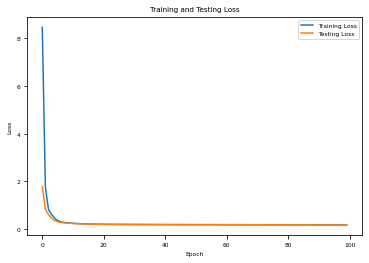

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)

        for l in range(layer_dim):
            weight_ih_name = f"weight_ih_l{l}"
            weight_ih = getattr(self.rnn, weight_ih_name)
            weight_ih.data.copy_(torch.eye(hidden_dim))
            weight_ih.requires_grad = False

        self.fc.weight.data.copy_(torch.eye(output_dim, hidden_dim))
        self.fc.weight.requires_grad = False

    def forward(self, x, k=1):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device).double()
        outputs = []
        for _ in range(k):
            out, h0 = self.rnn(x, h0)
            out = self.fc(out[:, -1, :])
            outputs.append(out)
            x = out.unsqueeze(1)
        return torch.stack(outputs, dim=1)

input_dim = 300
hidden_dim = 300
output_dim = 300
layer_dim = 1
k = 10
batch_size = 1
print(activity.shape)
activity_ = activity[:,:11]
activity_ = activity_.astype(np.float64) 
x_data = torch.from_numpy(activity_.reshape(1, 11, 300)).to(device)
x_train = x_data[:, :-k, :].to(device)
y_train = x_data[:, -k:, :].to(device)
x_test = x_data.to(device)
y_test = x_test[:, -k:, :].to(device)

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
model.double()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
training_losses = []
testing_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train.to(device), k)
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        outputs_test = model(x_test[:, :-k, :], k)
        loss_test = criterion(outputs_test, y_test.to(device))
        testing_losses.append(loss_test.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Training Loss: {loss.item()}, Testing Loss: {loss_test.item()}')

import matplotlib.pyplot as plt
plt.plot(training_losses, label='Training Loss')
plt.plot(testing_losses, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


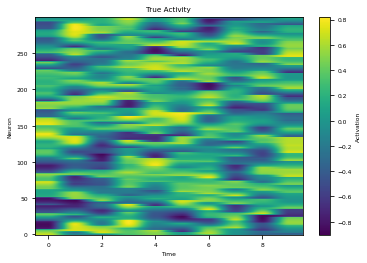

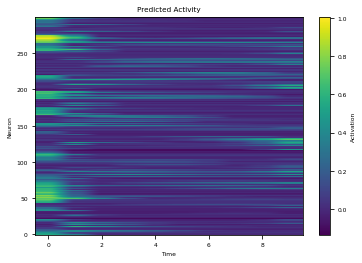

In [6]:
model.eval()
with torch.no_grad():
    predictions = model(x_test[:, :-k, :], k)

# Convert predictions to numpy array for plotting
predicted_activity = predictions.squeeze().cpu().numpy()

# Convert y_test to numpy array for plotting
true_activity = y_test.squeeze().cpu().numpy()

# Plot the true activity
plt.imshow(true_activity.T, aspect='auto', cmap='viridis', origin='lower')
plt.title('True Activity')
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.colorbar(label='Activation')
plt.show()

# Plot the predicted activity
plt.imshow(predicted_activity.T, aspect='auto', cmap='viridis', origin='lower')
plt.title('Predicted Activity')
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.colorbar(label='Activation')
plt.show()





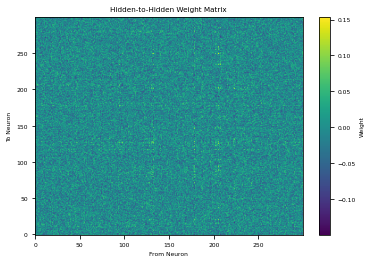

In [7]:
# Accessing the hidden-to-hidden weight matrix for the 0th layer
hidden_to_hidden_weight = model.rnn.weight_hh_l0.cpu().data.numpy()

# Plot the hidden-to-hidden weight matrix
plt.imshow(hidden_to_hidden_weight, aspect='auto', cmap='viridis', origin='lower')
plt.title('Hidden-to-Hidden Weight Matrix')
plt.xlabel('From Neuron')
plt.ylabel('To Neuron')
plt.colorbar(label='Weight')
plt.show()

(300, 101)
Epoch 0, Training Loss: 2.3129939412812342e+25, Testing Loss: 3.655365682203781e+30
Epoch 10, Training Loss: 1.0548689037566763e+25, Testing Loss: 1.3733016217889188e+25
Epoch 20, Training Loss: 5.248681820840328e+22, Testing Loss: 4.0328414903081196e+22
Epoch 30, Training Loss: 9.076797911355154e+21, Testing Loss: 7.834706047615208e+21
Epoch 40, Training Loss: 2.580591431878258e+21, Testing Loss: 2.2706920709589547e+21
Epoch 50, Training Loss: 1.0246305562539061e+21, Testing Loss: 9.670948276648142e+20
Epoch 60, Training Loss: 5.6228749616152786e+20, Testing Loss: 5.455893499645381e+20
Epoch 70, Training Loss: 3.821913138271784e+20, Testing Loss: 3.666597932693222e+20
Epoch 80, Training Loss: 2.908756232710628e+20, Testing Loss: 2.8362886155664343e+20
Epoch 90, Training Loss: 2.3591813161178635e+20, Testing Loss: 2.3165007029271747e+20


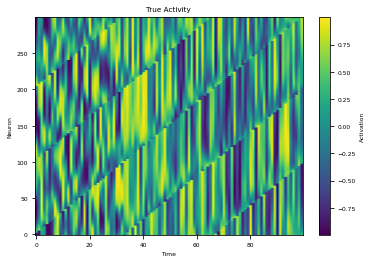

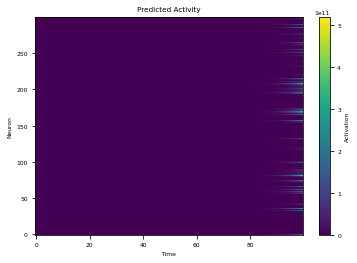

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)

        for l in range(layer_dim):
            weight_ih_name = f"weight_ih_l{l}"
            weight_ih = getattr(self.rnn, weight_ih_name)
            weight_ih.data.copy_(torch.eye(hidden_dim))
            weight_ih.requires_grad = False

        self.fc.weight.data.copy_(torch.eye(output_dim, hidden_dim))
        self.fc.weight.requires_grad = False

    def forward(self, x, k=1):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device).double()
        outputs = []
        for _ in range(k):
            out, h0 = self.rnn(x, h0)
            out = self.fc(out[:, -1, :])
            outputs.append(out)
            x = out.unsqueeze(1)
        return torch.stack(outputs, dim=1)

input_dim = 300
hidden_dim = 300
output_dim = 300
layer_dim = 1
k = 100
batch_size = 1
print(activity.shape)
activity = activity[:,:101]
activity = activity.astype(np.float64) 
x_data = torch.from_numpy(activity.reshape(1, 101, 300)).to(device)
x_train = x_data[:, :-k, :].to(device)
y_train = x_data[:, -k:, :].to(device)
x_test = x_data.to(device)
y_test = x_test[:, -k:, :].to(device)

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
model.double()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
training_losses = []
testing_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train.to(device), k)
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        outputs_test = model(x_test[:, :-k, :], k)
        loss_test = criterion(outputs_test, y_test.to(device))
        testing_losses.append(loss_test.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Training Loss: {loss.item()}, Testing Loss: {loss_test.item()}')


model.eval()
with torch.no_grad():
    predictions = model(x_test[:, :-k, :], k)

# Convert predictions to numpy array for plotting
predicted_activity = predictions.squeeze().cpu().numpy()

# Convert y_test to numpy array for plotting
true_activity = y_test.squeeze().cpu().numpy()

# Plot the true activity
plt.imshow(true_activity.T, aspect='auto', cmap='viridis', origin='lower')
plt.title('True Activity')
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.colorbar(label='Activation')
plt.show()

# Plot the predicted activity
plt.imshow(predicted_activity.T, aspect='auto', cmap='viridis', origin='lower')
plt.title('Predicted Activity')
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.colorbar(label='Activation')
plt.show()
